In [1]:
# Packages 
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output

import time

In [2]:
# get user name depending on computer
username = os.getlogin()

# path
image_test_path = os.path.join (r'P:\Projects\SPR998.41 - ES&S\Jetson TX2 Investigation\Working\Dataset\test\image')
mask_test_path = os.path.join (r'P:\Projects\SPR998.41 - ES&S\Jetson TX2 Investigation\Working\Dataset\test\mask')
image_train_path = os.path.join (r'P:\Projects\SPR998.41 - ES&S\Jetson TX2 Investigation\Working\Dataset\train\image')
mask_train_path = os.path.join (r'P:\Projects\SPR998.41 - ES&S\Jetson TX2 Investigation\Working\Dataset\train\mask')

In [3]:
# load images 
def load_image(file_path, size):
    image_array = []
    
    for filename in os.listdir(file_path):
               
        # get mask path and read mask
        image_path = os.path.join(file_path, filename)
        image_raw = cv2.imread(image_path)/255
          
        # Append to list
        image_array.append(tf.image.resize(image_raw, size))
        
    return np.stack(image_array, axis=0)

In [4]:
# load masks
def load_mask(file_path, size):
    mask_array = []
    
    for filename in os.listdir(file_path):
        
        # get mask path and read mask
        image_path = os.path.join(file_path, filename)
        image_raw = cv2.imread(image_path)
        image_raw = np.array(tf.image.resize(image_raw, size, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)).astype('int32')
        
        # filter mask into single channel categories
        image_out = np.zeros([image_raw.shape[0],image_raw.shape[1],1])
        
        image_out[np.where(image_raw[:,:,1]==255)] = 1   # Grass Pixel [0,255,0]
        image_out[np.where(image_raw[:,:,0]==51)] = 2    # Vegetation/tree [51,102,102]
        image_out[np.where(image_raw[:,:,0]==170)] = 3   # Roads [170,170,170]
        image_out[np.where(image_raw[:,:,0]==255)] = 4   # sky [255,120,0]     
    
        # Append to list
        mask_array.append(image_out)
        
    return  np.stack(mask_array, axis=0)

In [5]:
size = [128, 128]
image_test = load_image(image_test_path, size)
mask_test = load_mask(mask_test_path, size)
image_train = load_image(image_train_path, size)
mask_train = load_mask(mask_train_path, size)

In [6]:
# create full data set
image_array = np.concatenate((image_train, image_test), axis=0)
mask_array = np.concatenate((mask_train, mask_test), axis=0)

In [7]:
num_image = len(image_array)
num_mask = len(mask_array)

if num_image != num_mask:
    raise ImportError('Image data and mask data do not match!')
else:
     data_size = num_image   
    
print(num_image)
print(num_mask)

366
366


In [8]:
# Some parameters
batch_size = 32
val_split = 0.2
buffer_size = 1000

In [9]:
# size of train and test
train_size = int((1-val_split) * data_size)
test_size = int(data_size - train_size)

In [10]:
# shuffle the entire dataset to get random train and test data
seed = np.random.randint(0, 100000)  
np.random.seed(seed)  
np.random.shuffle(image_array)  
np.random.seed(seed)  
np.random.shuffle(mask_array) 

In [11]:
# Extract train and test dataset 
train_images, test_images = image_array[:train_size,:], image_array[train_size:,:]
train_masks, test_masks = mask_array[:train_size,:], mask_array[train_size:,:]

In [12]:
# investgate shape of image
print(train_images.shape)
print(train_masks.shape)

(292, 128, 128, 3)
(292, 128, 128, 1)


In [13]:
#create tf dataset objects
train = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
test = tf.data.Dataset.from_tensor_slices((test_images,test_masks)) 

In [14]:
# Data augmentation techniques
# Flip the image randomly
@tf.function
def image_flip(input_image, input_mask):
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.rot90(input_image, k=1)
#         input_mask = tf.image.rot90(input_mask, k=1)
        
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_up_down(input_image)
#         input_mask = tf.image.flip_up_down(input_mask)
    
    return input_image, input_mask


# Change the the colour of image randomly
@tf.function
def image_color(input_image, input_mask):

    input_image = tf.image.random_hue(input_image, 0.08)
    input_image = tf.image.random_saturation(input_image, 0.6, 1.6)
    input_image = tf.image.random_brightness(input_image, 0.05)
    input_image = tf.image.random_contrast(input_image, 0.7, 1.3)
    
    return input_image, input_mask

In [15]:
# Clip image and make sure image and mask are in the correct dtype
@tf.function
def clip_images(input_image,input_mask):
    return (tf.cast(tf.clip_by_value(input_image, 0, 1), tf.float32), tf.cast(input_mask,tf.int32))

In [16]:
# Function to combine all the data augmentation and processing functions
def dataset_transform(dataset, augmentations):
        
    # Add the augmentations to the dataset
    for f in augmentations:
        # Apply the augmentation, run 2 jobs in parallel.
        dataset = dataset.map(f, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
   
    dataset = dataset.map(clip_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [17]:
# Map the train dataset with tranformation for data augmentation
train = dataset_transform(train, [image_flip,image_color])

In [18]:
# Test out the transformation

# take from dataset
def take_dataset(dataset, num_rep):
    
    sample_image = []
    sample_mask = []
    
    for i in range(num_rep):
        
        for image,mask in dataset.take(1):
            
            if len(image.shape) == 4:
                sample_image.append(image[0])
                sample_mask.append(mask[0])
            else:    
                sample_image.append(image)
                sample_mask.append(mask)
                
    return sample_image,sample_mask

# plotting the repeated images
def plot_images(dataset, num_rep):
    
    image , mask = take_dataset(dataset, num_rep)
    
    plt.figure(figsize=(10, 10))
    for i in range(num_rep):        
                
        plt.subplot(1, num_rep, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.axis('off')
    
    plt.figure(figsize=(10, 10))
    for i in range(num_rep): 
        plt.subplot(1, num_rep, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.axis('off')
        
    plt.show()

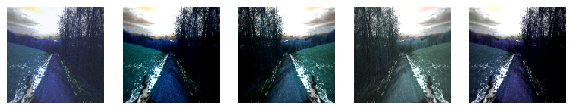

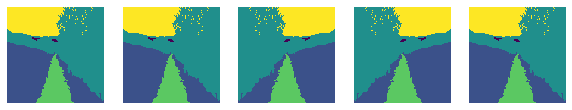

In [19]:
plot_images(train, 5)

In [20]:
# prepare data, return batches of data in iterator
train_dataset = train.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(batch_size)

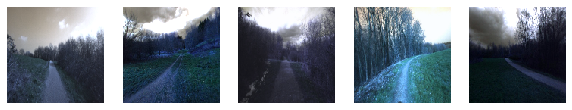

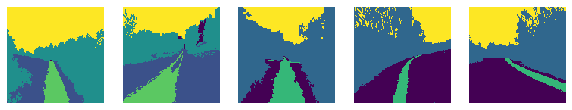

In [21]:
# Test images for shuffling 
plot_images(train_dataset,5)

In [22]:
# check unique catagorization
def check_mask_class(np_image):
    
    if len(np_image.shape) == 2:
        np_image = np.expand_dims(np_image,2)   
    
    reshape_size = np_image.shape[0]*np_image.shape[1]
    np_image = np.reshape(np_image,[reshape_size,np_image.shape[2]])
    
    return (np.unique(np_image,axis=0))

In [23]:
# Define a category map for {binary category : rbg pixel value}
class_map = {0: [0, 0, 0], 1: [0, 255, 0], 2: [51, 102, 102], 3 : [170, 170, 170], 4: [255, 120, 0]}

def display(display_list): # -> Enter a list of tf.tensor images
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        
        if i > 0:
            
            mask_in = display_list[i]
            mask_out = np.zeros(size + [3])
            category = check_mask_class(mask_in)
    
            for cat in category:    
                index = np.where(mask_in == cat[0])
                mask_out[index[0],index[1],: ] = class_map[cat[0]]
                
        else:
            mask_out = display_list[i]
        
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_out))
        plt.axis('off')
    plt.show()

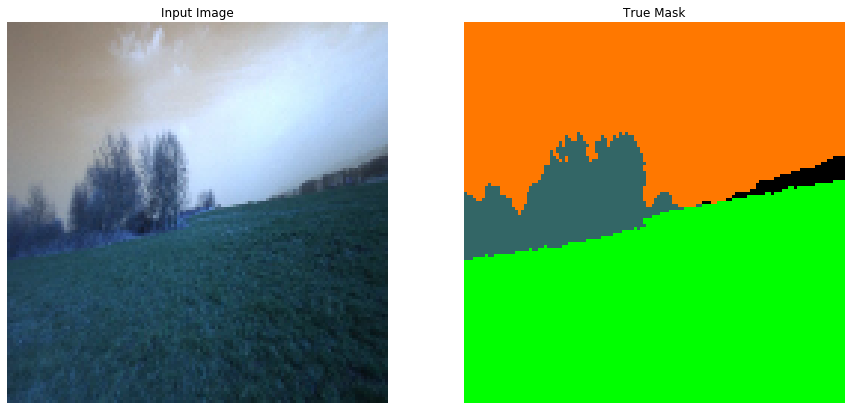

In [24]:
for image, mask in test.take(1):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

In [25]:
# Define model downsampling 
OUTPUT_CHANNELS = 5

base_model = tf.keras.applications.MobileNetV2(input_shape=size + [3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [26]:
# A summary of the base model
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [27]:
# define upsampling using pix2pix.upsample(#filters, filter_size)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='valid', activation='softmax')  #64x64 -> 128x128
    
    last_last = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)), data_format="channels_last")

    inputs = tf.keras.layers.Input(shape=size + [3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)
    x = last_last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

In [30]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [31]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

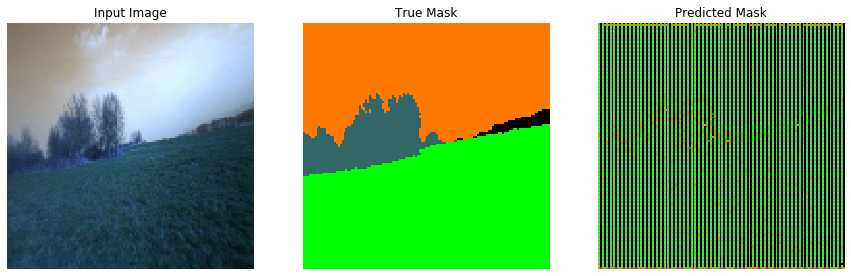

In [32]:
show_predictions()

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [34]:
export_path = r"C:\Users\\"+ username + r"\OneDrive - Science Group\Documents\Jetson GPU Project\forest_saved_model"
cp_callback = tf.keras.callbacks.ModelCheckpoint(export_path, 
                                                 monitor='val_accuracy', 
                                                 save_best_only=True,
                                                 save_weights_only=False)

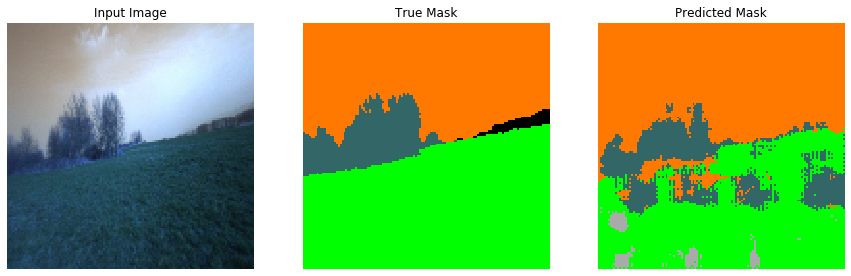


Sample Prediction after epoch 15

9/9 [==============================] - 33s 4s/step - loss: 0.2053 - accuracy: 0.9317 - val_loss: 0.6841 - val_accuracy: 0.7299
Time Elasped is: 535.877326965332


In [35]:
t1 = time.time()

EPOCHS = 15
STEPS_PER_EPOCH = train_size // batch_size
VALIDATION_STEPS = test_size // batch_size

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(),cp_callback])

t2 = time.time()
print("Time Elasped is:", t2 - t1)

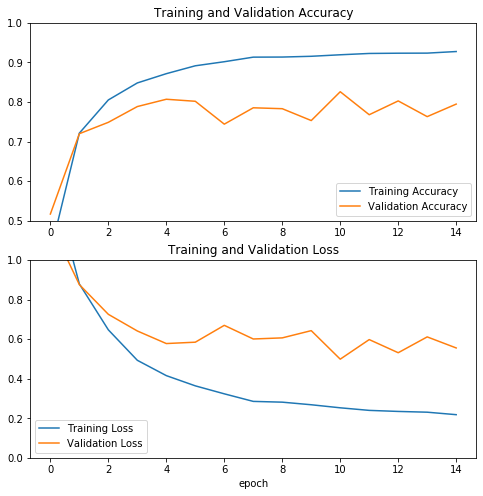

In [45]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

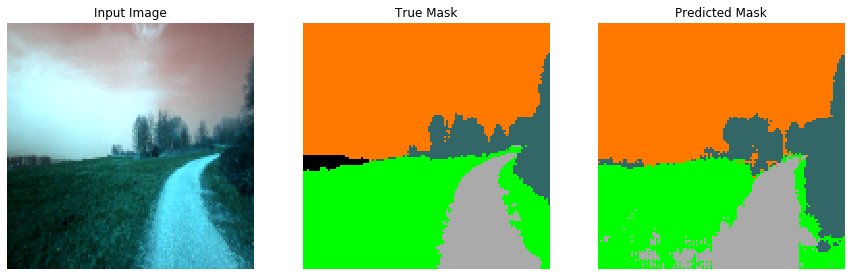

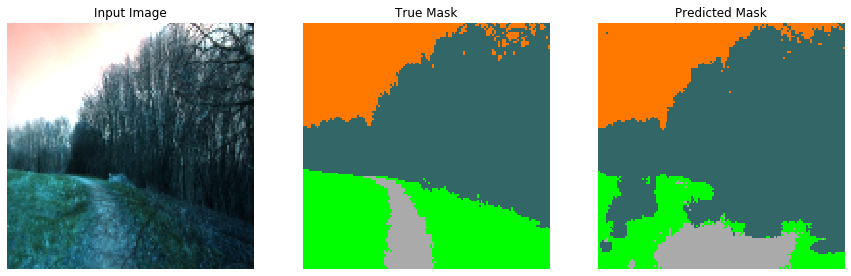

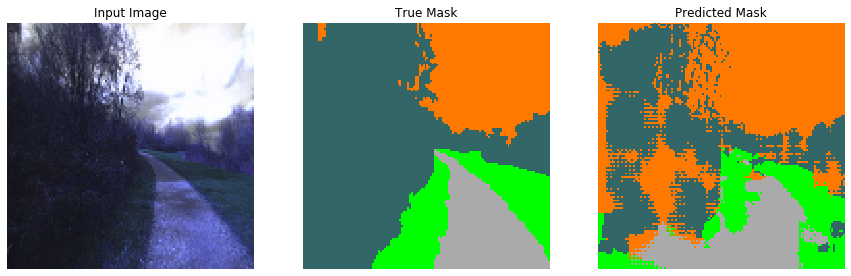

In [47]:
show_predictions(train_dataset, 3)

In [70]:
len(model.variables)

273

In [50]:
len(model.layers)

11